# Problem 1: Importance Sampling

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Fit a model to the data using:
a. Uniform priors on all parameters
b. Modestly informative Gaussian priors on all parameters
c. Strongly informative Gaussian priors on all parameters

Draw samples from the posterior using any sampler of your choosing.

After sampling in cases (b) and (c), calculate importance weights and resample your posteriors in order to "undo" the informative prior. This step will create a vector of unweighted posterior samples from your original vector of weighted posterior samples. Verify that after importance sampling your results are equivalent to what you obtained in case (a).

Examine the posterior distributions. Do you see any numerical noise or other sampling artifacts introduced by importance sampling?

# Problem 2: Umbrella Sampling Tutorial

Work through the umbrella sampling tutorial here: https://gjgilbert.github.io/tutorials/umbrella_sampling/

Once you complete the tutorial, return to the Line Fitting dataset from Problem 1. Fit a model using umbrella sampling. You'll need to choose how to define your umbrella windows and biases - there are many possible solutions! After sampling from individual umbrellas, combine your samples into a single set of posterior samples. Verify that the results you obtain from umbrella sampling are equivalent to the results you obtain from other methods.

# Problem 3: Reparameterizing a Model

Read in the Two Component Sinusoid dataset (two_component_sinusoid.csv) and plot the data.

Fit a model using the most "obvious" parameterization:

$y(x) = A_1 \sin(2\pi f_1 x - \phi_1 + A_2 \sin(2\pi f_2 x - \phi_2)$

Place appropriate independent priors on each of the six free parameters. Try fitting a model, drawing samples using a sampler of your choosing. Check for convergence and assess the quality of your results. Re-run your model a few times and check if your results remain consistent from run-to-run.

You will probably not acheive a very good fit using this parameterization. Why is this parameterization problematic? Re-parameterize the model in order to get a more robust fit. Check for convergence and that your posteriors remain consistent from run-to-run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pymc3 as pm
import pymc3_ext as pmx

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


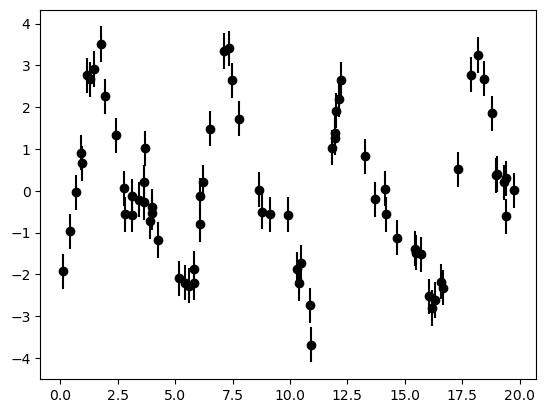

In [2]:
A1 = 2.1
A2 = A1 * 0.6

P1 = 5.5
P2 = P1 / 2

phi1 = 37/180*np.pi
phi2 = 101/180*np.pi


np.random.seed(42)

n = 75
x_obs = np.sort(np.random.uniform(0,20,n))
y_obs = A1*np.sin(2*np.pi*x_obs/P1 - phi1) + A2*np.sin(2*np.pi*x_obs/P2 - phi2) + np.random.normal(0, np.min([A1,A2])/3, n)
y_err = np.min([A1,A2])/3 * np.ones(n)

plt.figure()
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt='ko')
plt.show()

In [3]:
import pandas as pd

        
data = {"x": x_obs,
        "y": y_obs,
        "y_err": y_err,
       }

data = pd.DataFrame(data)

data.to_csv("two_component_sinusoid.csv")

In [4]:
with pm.Model() as model:
    A = pm.Uniform("A", lower=0, upper=10, shape=2)
    f = pm.Uniform("f", lower=0.01, upper=1, shape=2)
    
    phi = pm.Uniform("phi", lower=0, upper=2*np.pi, shape=2)
    
    y_mod = A[0]*pm.math.sin(2*np.pi*f[0]*x_obs - phi[0]) + A[1]*pm.math.sin(2*np.pi*f[1]*x_obs - phi[1])
    pm.Deterministic("y_mod", y_mod)
    
    lnlike = pm.Normal("lnlike", mu=y_mod, sd=y_err, observed=y_obs)
    
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[A])
    map_soln = pmx.optimize(start=map_soln, vars=[f, phi])
    trace = pmx.sample(tune=5000, draws=1000, chains=2, target_accept=0.9, return_inferencedata=True, start=map_soln)

optimizing logp for variables: [A]


message: Optimization terminated successfully.
logp: -10114.015979173475 -> -668.0113291081536
optimizing logp for variables: [phi, f]


message: Optimization terminated successfully.
logp: -668.0113291081536 -> -647.6586708163843


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, f, A]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.9601233021406821, but should be close to 0.9. Try to increase the number of tuning steps.


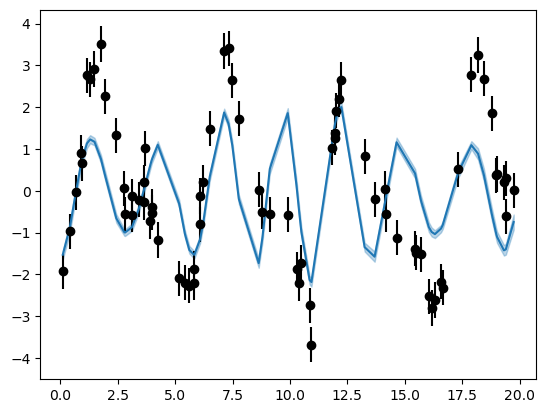

In [5]:
y_mod = np.percentile(trace.posterior.y_mod, [16,50,84], axis=[0,1])

plt.figure()
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt='ko')
plt.plot(x_obs, y_mod[1], color='C0')
plt.fill_between(x_obs, y_mod[0], y_mod[2], color='C0', alpha=0.3)
plt.show()

Now let's reparameterize using a slightly smarter parameterization:

$y(x) = A_1\sin(2\pi f x- phi_1) + A_2 \sin(2\pi f \beta - \phi_2)$

Where $\beta \sim U(0,1)$ is a *ratio* that defines $f_2$ in terms of $f_1$. The major advantage of this parameterization is that it *forces* the first component to have a higher frequency than the second. This prevents the frequencies from "crossing over" each other during sampling, which can confuse the sampler.

In [6]:
with pm.Model() as model:
    A = pm.Uniform("A", lower=0, upper=10, shape=2)
    f1 = pm.Uniform("f_1", lower=0.05, upper=1)
    beta = pm.Uniform("beta", lower=1e-4, upper=1.0)
    f2 = pm.Deterministic("f_2", f1*beta)
    
    phi = pm.Uniform("phi", lower=0, upper=2*np.pi, shape=2)
    
    y_mod = A[0]*pm.math.sin(2*np.pi*f1*x_obs - phi[0]) + A[1]*pm.math.sin(2*np.pi*f2*x_obs - phi[1])
    pm.Deterministic("y_mod", y_mod)
    
    lnlike = pm.Normal("lnlike", mu=y_mod, sd=y_err, observed=y_obs)
    
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[A])
    map_soln = pmx.optimize(start=map_soln, vars=[f1,f2,phi])
    trace = pmx.sample(tune=5000, draws=1000, chains=2, target_accept=0.9, return_inferencedata=True, start=map_soln)

optimizing logp for variables: [A]


message: Optimization terminated successfully.
logp: -6421.288763820071 -> -682.3988375926776


optimizing logp for variables: [phi, f_1, beta]


message: Optimization terminated successfully.
logp: -682.3988375926776 -> -631.8014424512403


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, beta, f_1, A]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 3 seconds.


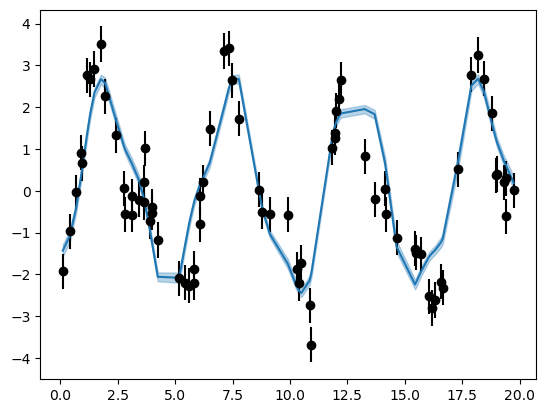

In [7]:
y_mod = np.percentile(trace.posterior.y_mod, [16,50,84], axis=[0,1])

plt.figure()
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt='ko')
plt.plot(x_obs, y_mod[1], color='C0')
plt.fill_between(x_obs, y_mod[0], y_mod[2], color='C0', alpha=0.3)
plt.show()

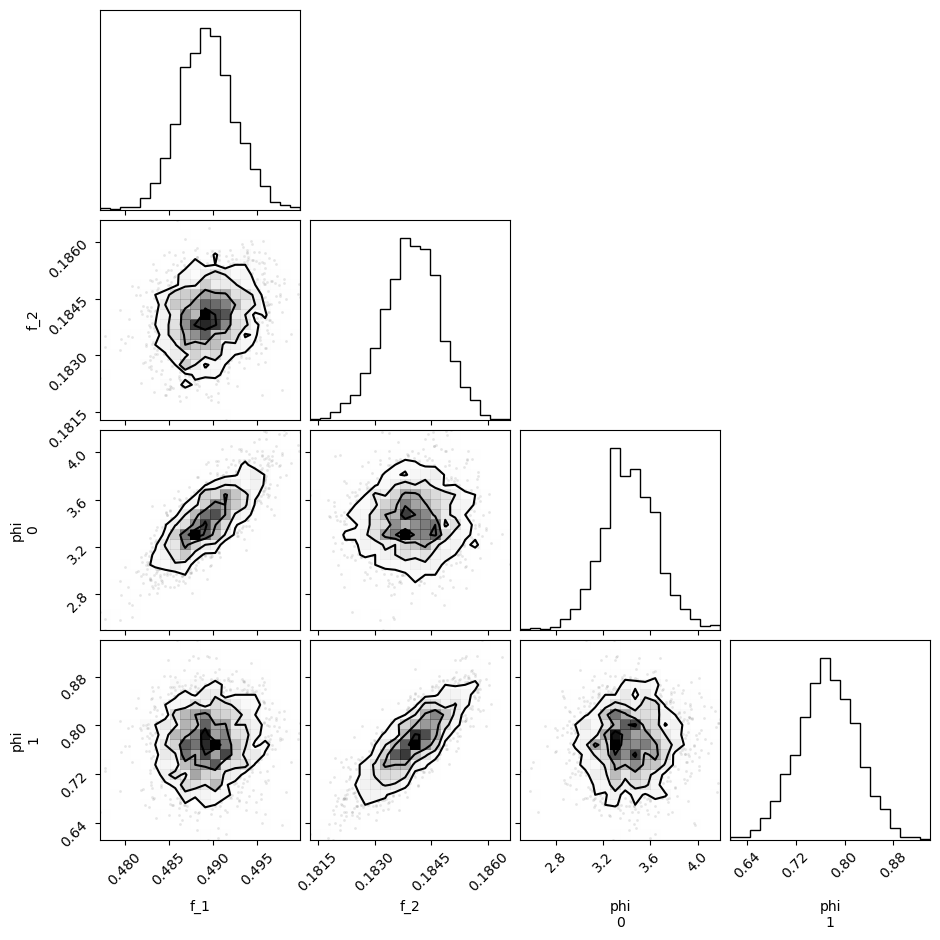

In [8]:
import corner

_ = corner.corner(trace, var_names=['f_1', 'f_2', 'phi'])

That was a little better, but still not great. Let's reparameterize to make things more orthoganal.

$y(x) = A\sin(2\pi f x) + B\cos(2\pi f x) + C\sin(2\pi f \beta) + D\cos(2\pi f \beta)$

Where we've used the trick of splitting a sinusoid into a sum of sine and cosine in order to eliminate the need for an explicit phase parameter.

In [9]:
with pm.Model() as model:
    A = pm.Uniform("A", lower=0, upper=5, shape=4)
    f = pm.Uniform("f", lower=0.05, upper=1)
    beta = pm.Uniform("beta", lower=1e-4, upper=1.0)
            
    y_mod = pm.Deterministic("y_mod", 
                             A[0]*pm.math.sin(2*np.pi*f*x_obs) +
                             A[1]*pm.math.cos(2*np.pi*f*x_obs) +
                             A[2]*pm.math.sin(2*np.pi*f*beta*x_obs) +
                             A[3]*pm.math.cos(2*np.pi*f*beta*x_obs)
                            )
    
    lnlike = pm.Normal("lnlike", mu=y_mod, sd=y_err, observed=y_obs)
    
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[A])
    map_soln = pmx.optimize(start=map_soln, vars=[f, beta])
    map_soln = pmx.optimize(start=map_soln)
    trace = pmx.sample(tune=9000, draws=1000, chains=2, target_accept=0.9, return_inferencedata=True, start=map_soln)

optimizing logp for variables: [A]


message: Optimization terminated successfully.
logp: -3896.937999582729 -> -686.0440925799834


optimizing logp for variables: [beta, f]


message: Optimization terminated successfully.
logp: -686.0440925799834 -> -675.8150620547581


optimizing logp for variables: [beta, f, A]


message: Optimization terminated successfully.
logp: -675.8150620547581 -> -602.7425823215543


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, f, A]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 9_000 tune and 1_000 draw iterations (18_000 + 2_000 draws total) took 18 seconds.


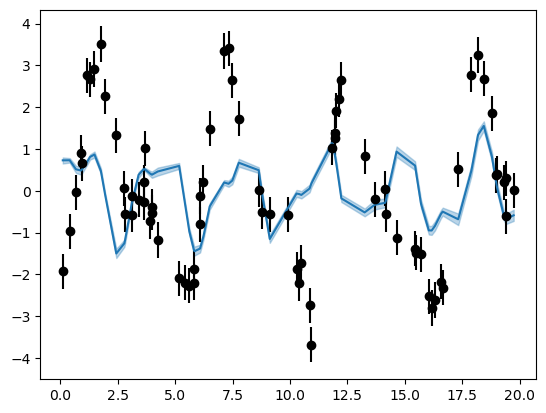

In [10]:
y_mod = np.percentile(trace.posterior.y_mod, [16,50,84], axis=[0,1])

plt.figure()
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt='ko')
plt.plot(x_obs, y_mod[1], color='C0')
plt.fill_between(x_obs, y_mod[0], y_mod[2], color='C0', alpha=0.3)
plt.show()